#  Assignment 2: Text Classification with a Feedforward Network



The goal of this assignment is to develop a Feedforward network for text classification. 


### Data 

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`


In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc
from pandas import *

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
# load the training, development and test sets
data_tr = pd.read_csv('data_topic/train.csv',header=None, names=['label','text'])
data_dev = pd.read_csv('data_topic/dev.csv',header=None, names=['label','text'])
data_test = pd.read_csv('data_topic/test.csv',header=None, names=['label','text'])

In [3]:
# put the raw texts into Python lists
train_text = [x.lower() for x in data_tr['text'].tolist()] 
dev_text = [x.lower() for x in data_dev['text'].tolist()] 
test_text = [x.lower() for x in data_test['text'].tolist()]

# put their corresponding labels into NumPy arrays
train_label = np.array(data_tr['label'])
dev_label = np.array(data_dev['label'])
test_label = np.array(data_test['label'])

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [4]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- `x` : a list of all extracted features.(Remove the same ngram)
- `text_ngrams` : a list of all extracted features.(split for several list by different rows of `x_raw`（Two-dimensional）)


In [5]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):    
    #create list x
    x = []
    #create list text_ngrams(store all extracted ngrams of documents)
    text_ngrams = []
    #extract texts according to different documents
    for raw in x_raw:
        #create list n_g_list(store a document of the extracted ngrams)  
        n_g_list = []
        # use stop_words to delete these words in document
        train_token = re.findall(token_pattern,raw)
        train_stop = []
        for raw_token in train_token:
            if raw_token not in stop_words:
                train_stop.append(raw_token)
        #use n_g_list list to save the extracted ngrams of a document.
        for i in range(min(ngram_range),max(ngram_range)+1):
            length = len(train_stop)-i+1
            for j in range(length):
                if i ==1:
                    unigram = train_stop[j]
                    x.append(unigram)
                    n_g_list.append(unigram)
                else:
                    ngrams = tuple(train_stop[j:j+i])
                    x.append(ngrams)
                    n_g_list.append(ngrams)
        text_ngrams.append(n_g_list)
    x = set(x)
    
    return x, text_ngrams


### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [6]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=5000, stop_words=[]):
    
    x, ngrams_list = extract_ngrams(x_raw=X_raw, ngram_range = ngram_range, stop_words=stop_words)
    
    df = {}    
    # use dict(df) to save all ngrams as keys and their corresponding document frequency as values               
    for grams in ngrams_list:
        grams_uni = set(grams)
        for n_gram in grams_uni:
            if n_gram not in df.keys():
                df[n_gram]=1
            else:
                df[n_gram]+=1

    #order by the dict.values              
    df = dict(sorted(df.items(), key=lambda x:x[1], reverse=True))
    #keep top-N more frequent ngrams
    df = {k: df[k] for k in list(df.keys())[:keep_topN]}
 
    vocab= [ i for i in df.keys()]
    ngram_counts= [ i for i in df.values()]
    
    return vocab, df, ngram_counts    
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [7]:
#according to train set to got my vocabulary as feature
vocab, tr_df, tr_ngram_counts = get_vocab(X_raw=train_text, ngram_range=(1,1), keep_topN=1000, stop_words=stop_words)

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [8]:
# create word dictionaries 
vocab_dict = {}
for i in range(len(vocab)):
    vocab_dict[vocab[i]] = i

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [9]:
#extract unigrams for each text in the training, development and test sets:
tr_x, X_uni_tr = extract_ngrams(x_raw = train_text, ngram_range=(1,1), stop_words=stop_words)
dev_x, X_uni_dev = extract_ngrams(x_raw = dev_text, ngram_range=(1,1), stop_words=stop_words)
test_x, X_uni_test = extract_ngrams(x_raw = test_text, ngram_range=(1,1), stop_words=stop_words)

In [10]:
X_uni_tr[0]

['reuters',
 'venezuelans',
 'turned',
 'out',
 'early',
 'large',
 'numbers',
 'sunday',
 'vote',
 'historic',
 'referendum',
 'either',
 'remove',
 'left',
 'wing',
 'president',
 'hugo',
 'chavez',
 'office',
 'give',
 'him',
 'new',
 'mandate',
 'govern',
 'next',
 'two',
 'years']

Then convert them into lists of indices in the vocabulary:

In [11]:
def convert_indices(X_uni_tr,vocab_dict):
    
    X_tr = []
    for i in range(len(X_uni_tr)):
        X_tr_raw = []
        for word in X_uni_tr[i]:
            if word in vocab_dict:
                vocab_id = vocab_dict[word]
                X_tr_raw.append(vocab_id)
        X_tr.append(X_tr_raw)
    
    return X_tr  
    

In [12]:
X_tr = convert_indices(X_uni_tr,vocab_dict)
X_dev = convert_indices(X_uni_dev,vocab_dict)
X_test = convert_indices(X_uni_test,vocab_dict)

In [13]:
X_tr[0]

[0,
 759,
 28,
 208,
 29,
 308,
 816,
 262,
 108,
 758,
 35,
 173,
 175,
 493,
 701,
 97,
 4,
 172,
 10,
 63]

#### Delete the Null value data after converting the list of unigrams into a list of vocabulary indices

In [14]:
def del_Nuldata(X,Y):
    
    X_new = []
    Y_new = []

    for i in range(len(X)):
        a = len(X[i])
        if a != 0:   
            X_new.append(X[i])
            Y_new.append(Y[i])
            
    return X_new,Y_new
    

In [15]:
X_tr, train_label = del_Nuldata(X_tr,train_label)
X_dev, dev_label = del_Nuldata(X_dev,dev_label)
X_test, test_label = del_Nuldata(X_test,test_label)

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W^T) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i^T $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers (for the Bonus). Empty if there are no hidden layers between the average embedding and the output layer 
- `num_clusses`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

See the examples below for expected outputs. Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [16]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    
    dim_list = []
    dim_list.append(vocab_size)
    dim_list.append(embedding_dim)
    dim_list.extend(hidden_dim)
    dim_list.append(num_classes)
    
    W={}
    for i in range(len(dim_list)-1):
        
        W[i] = np.random.uniform(-init_val,init_val,(dim_list[i],dim_list[i+1])).astype('float32')

    return W
    

In [17]:
W = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[], num_classes=2)

print('W_emb:', W[0].shape)
print('W_out:', W[1].shape)

W_emb: (5, 10)
W_out: (10, 2)


In [18]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

In [19]:
print('W_emb:', W[0].shape)
print('W_h1:', W[1].shape)
print('W_out:', W[2].shape)

W_emb: (3, 4)
W_h1: (4, 2)
W_out: (2, 2)


Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. It takes as input:

- `z`: array of real numbers 

and returns:

- `sig`: the softmax of `z`

In [20]:
def softmax(z):
    x_exp = np.exp(z)
    # If it is a one-dimensional array, then axis = 0, otherwise, axis = 1.
    if len(z.shape) >1:
        x_sum = np.sum(x_exp, axis = 1, keepdims = True)
    else:
        x_sum = np.sum(x_exp, axis = 0)
    sig = x_exp / x_sum    
    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:

In [21]:
def categorical_loss(y, y_preds):
    
    l = -np.log(y_preds[y])
    
    return l

In [22]:
# example for 5 classes

y = 2 #true label
y_preds = softmax(np.array([[-2.1,1.,0.9,-1.3,1.5]]))[0]

print('y_preds: ',y_preds)
print('loss:', categorical_loss(y, y_preds))

y_preds:  [0.01217919 0.27035308 0.24462558 0.02710529 0.44573687]
loss: 1.40802648485675


Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network (during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

\begin{equation}
  \text{relu_derivative}(z_i)=\begin{cases}
    0, & \text{if $z_i<=0$}.\\
    1, & \text{otherwise}.
  \end{cases}
\end{equation}

Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [23]:
def relu(z):
    
    a = np.maximum(z, 0)
    
    return a
    
def relu_derivative(z):
    
    z = np.array(z)
    z[z <= 0] = 0
    z[z > 0] = 1
    dz = z
    
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [24]:
def dropout_mask(size, dropout_rate):
    
    vec = np.ones(size)
    num_zero = int(size*dropout_rate)
    vec[:num_zero] = 0
    np.random.shuffle(vec)
    dropout_vec = vec
    
    return dropout_vec
    

In [25]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 1. 1. 0. 1. 0. 1. 1. 1.]
[1. 1. 1. 1. 1. 0. 1. 0. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [26]:
def forward_pass(x, W, dropout_rate=0.2):
    
    
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    out_vals = {}
    
    for i in range(len(W)-1):
        if i == 0:
            #Choose the input vector
            vec = [W[i][indice] for indice in x]
            h = np.sum(vec,axis = 0)/len(x)
        else:
            h = np.dot(output,W[i])
        # Apply Activation Function Relu
        a = relu(h)
        #Apply Dropout
        drop_vec = dropout_mask(len(a), dropout_rate)
        output = a*drop_vec
        
        h_vecs.append(h)
        a_vecs.append(a)
        dropout_vecs.append(drop_vec)
    # Apply Activation Function softmax   
    y_pre = softmax(np.dot(output,W[len(W)-1]))
    
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vecs'] = dropout_vecs
    out_vals['y'] = y_pre
         
    
    
    return out_vals
    

In [27]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[5], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

print()
print(forward_pass([2,1], W, dropout_rate=0.5))

Shape W0 (3, 4)
Shape W1 (4, 5)
Shape W2 (5, 2)

{'h': [array([-0.04668263, -0.12518334,  0.17532286, -0.32932055], dtype=float32), array([-0.01851934,  0.04051239, -0.05942235,  0.01765476,  0.0641444 ])], 'a': [array([0.        , 0.        , 0.17532286, 0.        ], dtype=float32), array([0.        , 0.04051239, 0.        , 0.01765476, 0.0641444 ])], 'dropout_vecs': [array([1., 0., 1., 0.]), array([0., 0., 1., 1., 1.])], 'y': array([0.48946731, 0.51053269])}


The `backward_pass` function computes the gradients and update the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [28]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False): 
    
    for i in range(len(W)-1):
        if i == 0:
            y_ture = np.zeros(W[len(W)-1].shape[1])
            y_ture[y-1] = 1
            g = out_vals['y'] - y_ture
            output = (out_vals['a'][-1]*out_vals['dropout_vecs'][-1]).reshape(W[len(W)-1].shape[0],1)
            dw = np.dot(output, g.reshape(1,W[len(W)-1].shape[1]))
            #Compute the gradient g
            g = (np.dot(W[len(W)-1],g).reshape(1,W[len(W)-1].shape[0]))* out_vals['dropout_vecs'][len(W)-2]
            #Update weights W
            W[len(W)-1] = W[len(W)-1] - lr*dw
        else:  
            g = g * relu_derivative(out_vals['h'][len(W)-1-i]).reshape(1, W[len(W)-i].shape[0])
            output = (out_vals['a'][len(W)-2-i]*out_vals['dropout_vecs'][len(W)-2-i]).reshape(W[len(W)-1-i].shape[0],1)
            dw = np.dot(output, g)
            #Compute the gradient g
            g = (np.dot(W[len(W)-1-i],g.T).reshape(1,W[len(W)-1-i].shape[0]))* out_vals['dropout_vecs'][len(W)-2-i]
            #Update weights W
            W[len(W)-1-i] = W[len(W)-1-i] - lr*dw
        
    #If freeze_emb is false, then update the W0, otherwise, do not update.
    if freeze_emb ==False:
        x_input = np.zeros([W[0].shape[0],1])
        x_input[x] = 1
        g = g*relu_derivative(out_vals['h'][0]).reshape(1, W[0].shape[1])
        dw = np.dot(x_input,g)
        #Update weights W0
        W[0] = W[0] - lr*dw            
    
    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [29]:
# This fuction is used to compute average loss for all data. 
def compute_loss(x, y, W, dropout_rate):
    
    loss_all = 0.0
    for i in range(len(x)):
        out_vals = forward_pass(x[i], W, dropout_rate)
        y_pre = out_vals['y']
        loss = categorical_loss(y[i]-1,y_pre)
        loss_all += loss
        loss_average = loss_all/(len(x))
        
    return loss_average

In [30]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):
    
    
    pre_loss_dev = 10.
    training_loss_history = []
    validation_loss_history = []
    
    
    #Perform multiple epochs over the training data 
    for i in range(epochs):
        #Randomise the order of training data after each epoch
        np.random.seed(i)
        new_X_tr = np.random.permutation(X_tr)
        np.random.seed(i)
        new_Y_tr = np.random.permutation(Y_tr)
        
        for j, X_tr_row in enumerate(new_X_tr):
            out_vals = forward_pass(X_tr_row, W, dropout_rate=dropout)
            W = backward_pass(X_tr_row, new_Y_tr[j], W, out_vals,lr=lr,freeze_emb=freeze_emb)
            
        #compute training loss
        train_loss = compute_loss(new_X_tr,new_Y_tr,W,dropout_rate=dropout)
        training_loss_history.append(train_loss)
        
        #compute validation set loss
        valid_loss = compute_loss(X_dev,Y_dev,W,dropout_rate=dropout)
        validation_loss_history.append(valid_loss)
        
        #After each epoch print the training and development loss
        if print_progress==True:
            print('Epoch: %d' % i, '| Training loss: %f' % train_loss, '| Validation loss: %f' % valid_loss)
        
        #Stop training if the difference between the current and previous validation loss is smaller than tolerance
        if (pre_loss_dev-valid_loss)<tolerance:
            break
        pre_loss_dev = valid_loss
     
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [31]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3, init_val = 0.1)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

Shape W0 (1000, 300)
Shape W1 (300, 3)


In [32]:
W, loss_tr, dev_loss = SGD(X_tr, Y_tr=train_label,
                                W=W,
                                X_dev=X_dev, 
                                Y_dev=dev_label,
                                lr=0.01, 
                                dropout=0.5,
                                freeze_emb=False,
                                print_progress=True,
                                tolerance=0.001,
                                epochs=50)

Epoch: 0 | Training loss: 1.085098 | Validation loss: 1.090768
Epoch: 1 | Training loss: 1.056785 | Validation loss: 1.071332
Epoch: 2 | Training loss: 0.989174 | Validation loss: 1.026021
Epoch: 3 | Training loss: 0.869137 | Validation loss: 0.932944
Epoch: 4 | Training loss: 0.730339 | Validation loss: 0.814517
Epoch: 5 | Training loss: 0.602586 | Validation loss: 0.687907
Epoch: 6 | Training loss: 0.508049 | Validation loss: 0.589408
Epoch: 7 | Training loss: 0.435026 | Validation loss: 0.505415
Epoch: 8 | Training loss: 0.382233 | Validation loss: 0.472904
Epoch: 9 | Training loss: 0.339317 | Validation loss: 0.414432
Epoch: 10 | Training loss: 0.311210 | Validation loss: 0.398562
Epoch: 11 | Training loss: 0.288879 | Validation loss: 0.363073
Epoch: 12 | Training loss: 0.267523 | Validation loss: 0.370407


Plot the learning process:

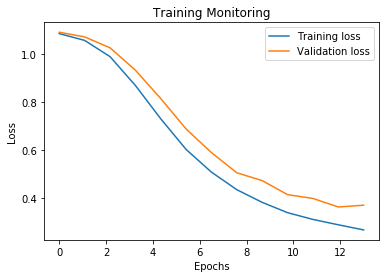

In [33]:
x = np.linspace(0,len(loss_tr),len(loss_tr))
y1, y2 = loss_tr, dev_loss
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [34]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_test,test_label)]
print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))

Accuracy: 0.8541202672605791
Precision: 0.8553989651416122
Recall: 0.8540431066518024
F1-Score: 0.8537385554939777


### Discuss how did you choose model hyperparameters ? 

In [35]:
# choose model hyperparameters: learning rate and regularisation strength
embedding_dim_hyper = [100,300]
lr_hyper = [0.01,0.001]
dropout_hyper = [0.2,0.5]
result_all = []
result = []
hyper_list = []
for emb in range(len(embedding_dim_hyper)):
    for lr in range(len(lr_hyper)):
        for drop in range(len(dropout_hyper)):
            W = network_weights(vocab_size=len(vocab),embedding_dim=embedding_dim_hyper[emb],hidden_dim=[], num_classes=3, init_val = 0.1)
            W, loss_tr, dev_loss = SGD(X_tr, Y_tr=train_label,
                                W=W,
                                X_dev=X_dev, 
                                Y_dev=dev_label,
                                lr=lr_hyper[lr], 
                                dropout=dropout_hyper[drop],
                                freeze_emb=False,
                                print_progress=False,
                                tolerance=0.001,
                                epochs=50)
            #The performance of the training for each hyperparam combination 
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_tr,train_label)]
            tr_f1 = f1_score(train_label, preds_te, average='macro')
            result.append(tr_f1)
           
            #The performance of the  validation for each hyperparam combination 
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_dev,dev_label)]
            dev_f1 = f1_score(dev_label, preds_te, average='macro')
            result.append(dev_f1)
            
            #The performance of the test for each hyperparam combination 
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_test,test_label)]
            test_f1 = f1_score(test_label, preds_te, average='macro')
            result.append(test_f1)
            result_all.append(result)
            print("The F1_score of training, validation and test for each hyperparam combination: "+str(result)+"\n")
            result = [] 
            hyper = 'emb_dim={emb}, lr={lr}, dropout={dropout}'
            hyper = hyper.format(emb=embedding_dim_hyper[emb], lr=lr_hyper[lr], dropout=dropout_hyper[drop])
            hyper_list.append(hyper)
                   

The F1_score of training, validation and test for each hyperparam combination: [0.9230797575506674, 0.9011104089554934, 0.843015447391184]

The F1_score of training, validation and test for each hyperparam combination: [0.9243778645202626, 0.9014987401748696, 0.8518404333241109]

The F1_score of training, validation and test for each hyperparam combination: [0.5167834514816145, 0.3488359580184888, 0.4515225913215685]

The F1_score of training, validation and test for each hyperparam combination: [0.47927259667358496, 0.3741314929277235, 0.4698517638376884]

The F1_score of training, validation and test for each hyperparam combination: [0.9555596129353071, 0.9073924989586337, 0.839624875453102]

The F1_score of training, validation and test for each hyperparam combination: [0.9179345401523261, 0.8944862155388472, 0.8561013907738996]

The F1_score of training, validation and test for each hyperparam combination: [0.9037584933163155, 0.8875661375661376, 0.8334734128314416]

The F1_score o

### The function plot_table can be used to plot tables. 

In [36]:
def plot_table(row, col, vals):
    
    R, C = len(row), len(col)
    idx = Index(row)
    df = DataFrame(np.random.randn(R, C), index=idx, columns=col)
    # Adjust the table size
    figC, figR = 4*C, 1.5*R
    fig = plt.figure(figsize=(figC, figR))
    
    ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    the_table=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, colWidths = [0.1]*vals.shape[1], rowLoc='center', loc='center',cellLoc='center')
    the_table.set_fontsize(20)
    
    the_table.scale(figR/R*2 ,figC/C*1.5)
 

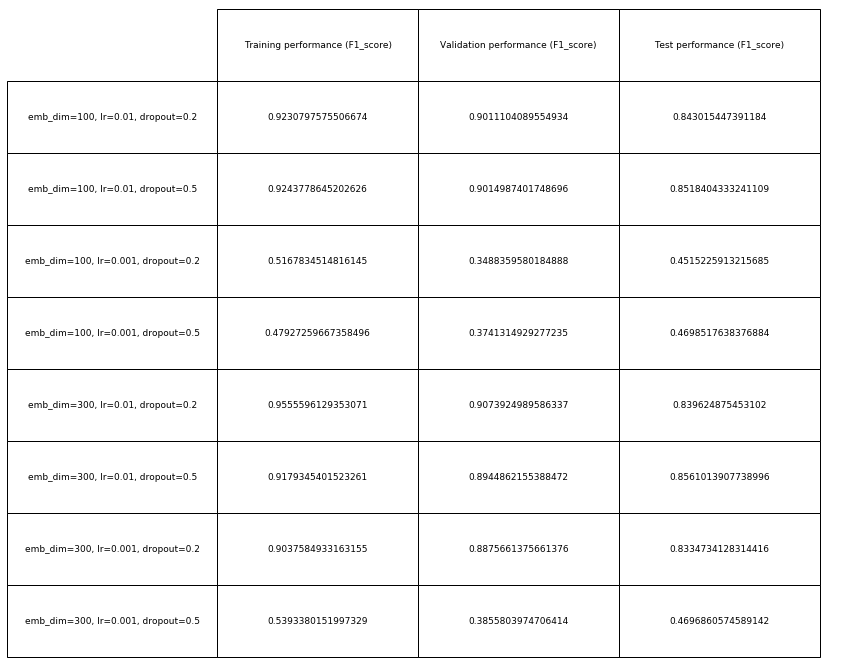

In [37]:
col = ["Training performance (F1_score)","Validation performance (F1_score)","Test performance (F1_score)"]
row = hyper_list
vals = np.array(result_all)

plot_table(row, col, vals)

When emb_dim=300, Ir=0.01, dropout=0.5, the model basically has no overfitting problem, and the test data has the best performance. In addition, generally, the model performs better when dropout=0.5 compared with the dropout=0.2.

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary.

In [38]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [39]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id = vocab_dict)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [40]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3, init_val = 0.1)
#Replace the weigths of the embedding matrix with w_glove
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

Shape W0 (1000, 300)
Shape W1 (300, 3)


In [41]:
W, loss_tr, dev_loss = SGD(X_tr, Y_tr=train_label,
                                W=W,
                                X_dev=X_dev, 
                                Y_dev=dev_label,
                                lr=0.01, 
                                dropout=0.5,
                                freeze_emb=True,
                                print_progress=True,
                                tolerance=0.0001,
                                epochs=50)

Epoch: 0 | Training loss: 0.876189 | Validation loss: 0.892723
Epoch: 1 | Training loss: 0.757452 | Validation loss: 0.771611
Epoch: 2 | Training loss: 0.689007 | Validation loss: 0.679717
Epoch: 3 | Training loss: 0.634810 | Validation loss: 0.620647
Epoch: 4 | Training loss: 0.599643 | Validation loss: 0.586200
Epoch: 5 | Training loss: 0.573217 | Validation loss: 0.563119
Epoch: 6 | Training loss: 0.552804 | Validation loss: 0.561694
Epoch: 7 | Training loss: 0.540812 | Validation loss: 0.485165
Epoch: 8 | Training loss: 0.524291 | Validation loss: 0.499837


Plot the learning process:

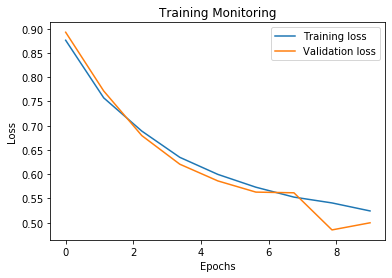

In [42]:
x = np.linspace(0,len(loss_tr),len(loss_tr))
y1, y2 = loss_tr, dev_loss
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [43]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_test,test_label)]
print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))

Accuracy: 0.8663697104677061
Precision: 0.8660034582359087
Recall: 0.8662987736900781
F1-Score: 0.8657112503413825


##### We re-train the network by using pre-trained embeddings (GloVe) trained on large corpora, and from above results , we can see that we got better performance.

### Discuss how did you choose model hyperparameters ? 

In [44]:
# choose model hyperparameters: learning rate and regularisation strength
lr_hyper = [0.01,0.001]
dropout_hyper = [0.2,0.4,0.6]
result_all = []
result = []
hyper_list = []

for lr in range(len(lr_hyper)):
    for drop in range(len(dropout_hyper)):
        W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3, init_val = 0.1)
        W[0] = w_glove
        W, loss_tr, dev_loss = SGD(X_tr, Y_tr=train_label,
                            W=W,
                            X_dev=X_dev, 
                            Y_dev=dev_label,
                            lr=lr_hyper[lr], 
                            dropout=dropout_hyper[drop],
                            freeze_emb=True,
                            print_progress=False,
                            tolerance=0.001,
                            epochs=50)
        #The performance of the training for each hyperparam combination 
        preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_tr,train_label)]
        tr_f1 = f1_score(train_label, preds_te, average='macro')
        result.append(tr_f1)
           
        #The performance of the  validation for each hyperparam combination 
        preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_dev,dev_label)]
        dev_f1 = f1_score(dev_label, preds_te, average='macro')
        result.append(dev_f1)
            
        #The performance of the test for each hyperparam combination 
        preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_test,test_label)]
        test_f1 = f1_score(test_label, preds_te, average='macro')
        result.append(test_f1)
        result_all.append(result)
        print("The F1_score of training, validation and test for each hyperparam combination: "+str(result)+"\n")
        result = [] 
        hyper = 'lr={lr}, dropout={dropout}'
        hyper = hyper.format(lr=lr_hyper[lr], dropout=dropout_hyper[drop])
        hyper_list.append(hyper)

The F1_score of training, validation and test for each hyperparam combination: [0.8863323308229472, 0.9074194324194323, 0.8640093018260552]

The F1_score of training, validation and test for each hyperparam combination: [0.8804862978600254, 0.9074194324194323, 0.8672576412221299]

The F1_score of training, validation and test for each hyperparam combination: [0.8748735126179166, 0.9007417243414347, 0.865834879818971]

The F1_score of training, validation and test for each hyperparam combination: [0.8677133930408263, 0.9002820803678088, 0.8633908553592927]

The F1_score of training, validation and test for each hyperparam combination: [0.8622258522463141, 0.887302625205851, 0.8619812595864755]

The F1_score of training, validation and test for each hyperparam combination: [0.841993103412278, 0.8743521747554005, 0.8418336596236541]



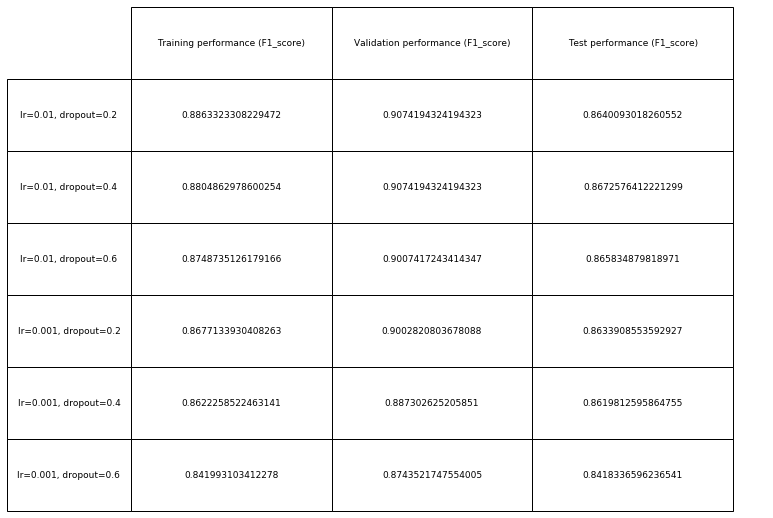

In [45]:
#Use plot_table fuction to plot table
col = ["Training performance (F1_score)","Validation performance (F1_score)","Test performance (F1_score)"]
row = hyper_list
vals = np.array(result_all)

plot_table(row, col, vals)

#### We got better results compared with previous methods.

# Extend to support deeper architectures (Bonus)

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. 

In [50]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[200,100], num_classes=3, init_val = 0.1)
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

Shape W0 (1000, 300)
Shape W1 (300, 200)
Shape W2 (200, 100)
Shape W3 (100, 3)


In [51]:
W, loss_tr, dev_loss = SGD(X_tr, Y_tr=train_label,
                                W=W,
                                X_dev=X_dev, 
                                Y_dev=dev_label,
                                lr=0.01, 
                                dropout=0.5,
                                freeze_emb=True,
                                print_progress=True,
                                tolerance=0.0001,
                                epochs=50)

Epoch: 0 | Training loss: 1.097346 | Validation loss: 1.098555
Epoch: 1 | Training loss: 1.094715 | Validation loss: 1.097254
Epoch: 2 | Training loss: 1.089905 | Validation loss: 1.094537
Epoch: 3 | Training loss: 1.074089 | Validation loss: 1.075473
Epoch: 4 | Training loss: 1.021434 | Validation loss: 1.011303
Epoch: 5 | Training loss: 0.856669 | Validation loss: 0.859397
Epoch: 6 | Training loss: 0.676814 | Validation loss: 0.613226
Epoch: 7 | Training loss: 0.548936 | Validation loss: 0.541251
Epoch: 8 | Training loss: 0.537190 | Validation loss: 0.466192
Epoch: 9 | Training loss: 0.499057 | Validation loss: 0.450908
Epoch: 10 | Training loss: 0.498851 | Validation loss: 0.485478


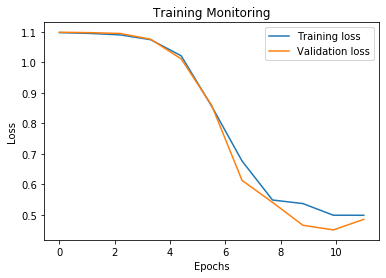

In [52]:
x = np.linspace(0,len(loss_tr),len(loss_tr))
y1, y2 = loss_tr, dev_loss
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

In [53]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_test,test_label)]
print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))

Accuracy: 0.876391982182628
Precision: 0.8773185280917151
Recall: 0.876317354143441
F1-Score: 0.8753218882950242


#### The hidden layers affect the performance of the model training.

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.855 | 0.854 | 0.854 | 0.854 |
| Average Embedding (Pre-trained)  | 0.866 | 0.866 | 0.866 | 0.866 |
| Average Embedding (Pre-trained) + X hidden layers (BONUS)   | 0.877 | 0.876 | 0.875 | 0.876 |
